# Author : Sujit Mandal

In [4]:
!pip install --upgrade tensorflow-model-optimization

In [6]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import backend
import tensorflow_model_optimization as tfmot
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Github: https://github.com/sujitmandal
# Pypi : https://pypi.org/user/sujitmandal/
# LinkedIn : https://www.linkedin.com/in/sujit-mandal-91215013a/

In [9]:
EPOCHS = 10
CHANNELS = 3
INIT_LR = 1e-3 # 0.001
Image_Size = 0
BATCH_SIZE = 32
IMAGE_SIZE = 256
dataset_dir = 'dataset'
AUTOTUNE = tf.data.AUTOTUNE
DEFAULT_IMAGE_SIZE = tuple((IMAGE_SIZE, IMAGE_SIZE))

In [13]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    seed = 123,
    image_size=DEFAULT_IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 2475 files belonging to 2 classes.


In [15]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

In [21]:
total_class = len(class_names)
total_class

2

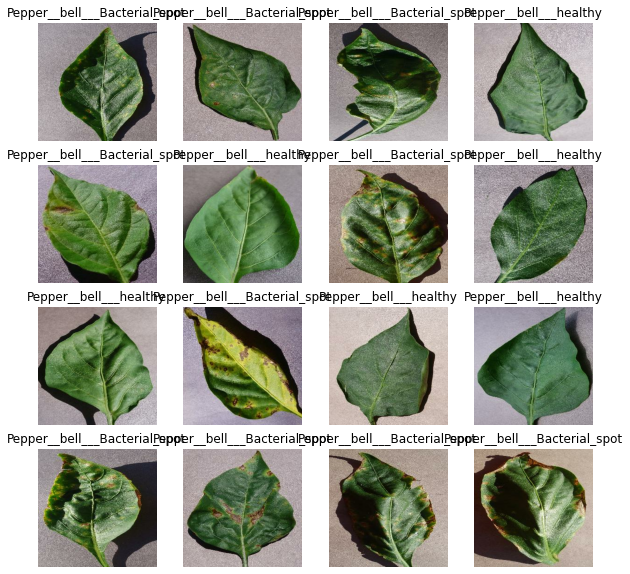

In [22]:
plt.figure(figsize=(10, 10))
for batch, label in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(batch[i].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")

In [23]:
def split_dataset(dataset, train_split, val_split, test_split):
    # shuffle = True
    # shuffle_size = 10000
    assert(train_split + val_split + test_split) == 1

    dataset_size = len(dataset)

    # if shuffle:
    #     dataset = dataset.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)

    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size).skip(val_size)

    return(train_dataset, val_dataset, test_dataset)

In [24]:
train_split = 0.8
val_split = 0.1
test_split = 0.1

train_dataset, val_dataset, test_dataset = split_dataset(dataset, train_split, val_split, test_split)

In [25]:
print('Total dataset : {}'.format(len(dataset)))
print('Train dataset : {}'.format(len(train_dataset)))
print('Val dataset : {}'.format(len(val_dataset)))
print('Test dataset : {}'.format(len(test_dataset)))

Total dataset : 78
Train dataset : 62
Val dataset : 7
Test dataset : 9


# Checking Batch Size

In [27]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


# Cache, Shuffle, and Prefetch the Dataset

In [28]:
# train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
# val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
# test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Resizing and Normalization

In [29]:
data_resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

# Data Augmentation

In [31]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

# Checking what is the expected dimension order for channel

In [36]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
batch_input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
channel_dim = -1

if backend.image_data_format() == 'channels_first':
    input_shape = (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    batch_input_shape = (BATCH_SIZE, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    channel_dim = 1

# build CNN model

In [37]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model = models.Sequential([
    data_resize_rescale,
    data_augmentation,

    layers.Conv2D(32, kernel_size = (3, 3), activation = 'relu', input_shape= input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'), 
    layers.Dense(total_class, activation = 'softmax'),
])

model.build(input_shape=input_shape)

# Model Summary

In [38]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

# compiling the model

In [40]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Train the model

In [41]:
history = model.fit(
    train_dataset,
    batch_size = BATCH_SIZE,
    validation_data = val_dataset,
    verbose = 1,
    epochs = EPOCHS,
)

Epoch 1/10
62/62 [==============================] - 334s 5s/step - loss: 0.6748 - accuracy: 0.5963 - val_loss: 0.5689 - val_accuracy: 0.7768
Epoch 2/10
62/62 [==============================] - 456s 7s/step - loss: 0.4066 - accuracy: 0.8438 - val_loss: 0.2141 - val_accuracy: 0.9286
Epoch 3/10
62/62 [==============================] - 467s 7s/step - loss: 0.1923 - accuracy: 0.9342 - val_loss: 0.3335 - val_accuracy: 0.8571
Epoch 4/10
62/62 [==============================] - 435s 7s/step - loss: 0.1691 - accuracy: 0.9524 - val_loss: 0.1196 - val_accuracy: 0.9464
Epoch 5/10
62/62 [==============================] - 459s 7s/step - loss: 0.0888 - accuracy: 0.9729 - val_loss: 0.1008 - val_accuracy: 0.9598
Epoch 6/10
62/62 [==============================] - 301s 5s/step - loss: 0.0666 - accuracy: 0.9813 - val_loss: 0.0202 - val_accuracy: 1.0000
Epoch 7/10
62/62 [==============================] - 242s 4s/step - loss: 0.0369 - accuracy: 0.9910 - val_loss: 0.0509 - val_accuracy: 0.9821
Epoch 8/10
62

In [42]:
model_score = model.evaluate(test_dataset)

9/9 [==============================] - 6s 327ms/step - loss: 0.0707 - accuracy: 0.9625


In [67]:
model_score

[0.07071582227945328, 0.9625468254089355]

# Testing the Model

In [68]:
print("Calculating model accuracy")
print(f"Test Accuracy: {round(model_score[1],4)*100}%")

Calculating model accuracy
Test Accuracy: 96.25%


In [69]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [70]:
import json

model_performance = history.history
print(json.dumps(model_performance, indent=4))

{
    "loss": [
        0.6454034447669983,
        0.3637058436870575,
        0.1976560801267624,
        0.1955167055130005,
        0.09432781487703323,
        0.07911065220832825,
        0.048689667135477066,
        0.03493742644786835,
        0.036988355219364166,
        0.04022004455327988
    ],
    "accuracy": [
        0.6300403475761414,
        0.8543346524238586,
        0.9334677457809448,
        0.9495967626571655,
        0.975806474685669,
        0.977318525314331,
        0.9858871102333069,
        0.991431474685669,
        0.9909273982048035,
        0.9873992204666138
    ],
    "val_loss": [
        0.5688905119895935,
        0.21409405767917633,
        0.3335092067718506,
        0.11959721148014069,
        0.10084307193756104,
        0.02024770900607109,
        0.050857480615377426,
        0.06855384260416031,
        0.0068879337050020695,
        0.0811956524848938
    ],
    "val_accuracy": [
        0.7767857313156128,
        0.928571403026580

In [71]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

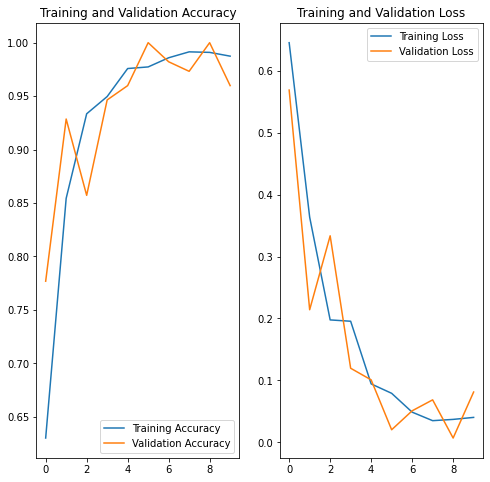

In [72]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label='Training Accuracy')
plt.plot(range(EPOCHS), val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Quantize only the Dense, MaxPool2D, Conv2D Layers

In [46]:
def apply_quantization(layer):
    if (
        isinstance(layer, layers.Dense)
        or isinstance(layer, layers.MaxPool2D)
        or isinstance(layer, layers.Conv2D)
    ):
        return tfmot.quantization.keras.quantize_annotate_layer(layer)
    
    return(layer)

# Clone the Model and Make Quantization

In [47]:
annotated_model = tf.keras.models.clone_model(
    model,
    clone_function=apply_quantization,
)

quant_model = tfmot.quantization.keras.quantize_apply(annotated_model)
quant_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 256, 256, 3)       0         
_________________________________________________________________
quant_conv2d (QuantizeWrappe (None, 254, 254, 32)      963       
_________________________________________________________________
quant_max_pooling2d (Quantiz (None, 127, 127, 32)      1         
_________________________________________________________________
quant_conv2d_1 (QuantizeWrap (None, 125, 125, 64)      18627     
_________________________________________________________________
quant_max_pooling2d_1 (Quant (None, 62, 62, 64)        1         
_________________________________________________________________
quant_conv2d_2 (QuantizeWrap (None, 60, 60, 64)       

# Compile Quantization Model before Fine Tuning

In [48]:
quant_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Fine Tuning the Quantization Model

In [49]:
quant_history = quant_model.fit(train_dataset,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    verbose=1,
    epochs=10,
)

Epoch 1/10
62/62 [==============================] - 264s 4s/step - loss: 0.0434 - accuracy: 0.9841 - val_loss: 0.3848 - val_accuracy: 0.8125
Epoch 2/10
62/62 [==============================] - 290s 5s/step - loss: 0.0248 - accuracy: 0.9897 - val_loss: 0.0059 - val_accuracy: 1.0000
Epoch 3/10
62/62 [==============================] - 287s 5s/step - loss: 0.0300 - accuracy: 0.9933 - val_loss: 0.2008 - val_accuracy: 0.9420
Epoch 4/10
62/62 [==============================] - 319s 5s/step - loss: 0.0983 - accuracy: 0.9725 - val_loss: 0.0187 - val_accuracy: 0.9955
Epoch 5/10
62/62 [==============================] - 343s 6s/step - loss: 0.0317 - accuracy: 0.9926 - val_loss: 0.0102 - val_accuracy: 0.9955
Epoch 6/10
62/62 [==============================] - 309s 5s/step - loss: 0.0193 - accuracy: 0.9926 - val_loss: 0.0143 - val_accuracy: 0.9911
Epoch 7/10
62/62 [==============================] - 318s 5s/step - loss: 0.0126 - accuracy: 0.9959 - val_loss: 0.1004 - val_accuracy: 0.9464
Epoch 8/10
62

# Evaluate the Model Accuracy

In [50]:
print("Calculating Quant model accuracy")
quant_model_score = quant_model.evaluate(test_dataset)
print(f"Test Accuracy: {round(quant_model_score[1],4)*100}%")

Calculating Quant model accuracy
9/9 [==============================] - 6s 379ms/step - loss: 0.0138 - accuracy: 0.9925
Test Accuracy: 99.25%


In [51]:
quant_model_score

[0.01382137555629015, 0.9925093650817871]

In [60]:
quant_history.params

{'verbose': 1, 'epochs': 10, 'steps': 62}

In [75]:
quant_model_performance = quant_history.history

print(json.dumps(model_performance, indent=4))

{
    "loss": [
        0.6454034447669983,
        0.3637058436870575,
        0.1976560801267624,
        0.1955167055130005,
        0.09432781487703323,
        0.07911065220832825,
        0.048689667135477066,
        0.03493742644786835,
        0.036988355219364166,
        0.04022004455327988
    ],
    "accuracy": [
        0.6300403475761414,
        0.8543346524238586,
        0.9334677457809448,
        0.9495967626571655,
        0.975806474685669,
        0.977318525314331,
        0.9858871102333069,
        0.991431474685669,
        0.9909273982048035,
        0.9873992204666138
    ],
    "val_loss": [
        0.5688905119895935,
        0.21409405767917633,
        0.3335092067718506,
        0.11959721148014069,
        0.10084307193756104,
        0.02024770900607109,
        0.050857480615377426,
        0.06855384260416031,
        0.0068879337050020695,
        0.0811956524848938
    ],
    "val_accuracy": [
        0.7767857313156128,
        0.928571403026580

In [76]:
quant_accuracy = quant_history.history['accuracy']
quant_val_accuracy = quant_history.history['val_accuracy']

quant_loss = quant_history.history['loss']
quant_val_loss = quant_history.history['val_loss']

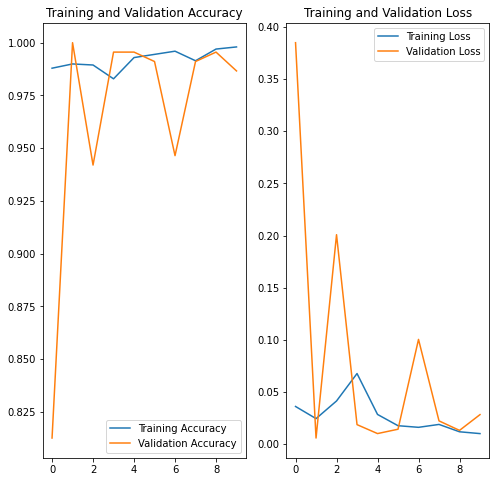

In [77]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), quant_accuracy, label='Training Accuracy')
plt.plot(range(EPOCHS), quant_val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), quant_loss, label='Training Loss')
plt.plot(range(EPOCHS), quant_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Convert Quanitzation Model to TF Lite Mode

In [55]:
# Convert the Model
converter = tf.lite.TFLiteConverter.from_keras_model(quant_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp1h4er8hk/assets


INFO:tensorflow:Assets written to: /tmp/tmp1h4er8hk/assets


# Evaluate the TF Lite Model

In [56]:
def evaluate_tflite_model(dataset, interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    prediction_digits = []
    test_labels = []
    for image, label in dataset.unbatch().take(dataset.unbatch().cardinality()):

        test_image = np.expand_dims(image, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)
        interpreter.invoke()
        
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)
        test_labels.append(label)

    prediction_digits = np.array(prediction_digits)
    accuracy = (prediction_digits == test_labels).mean()
    
    return(accuracy)

interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
interpreter.allocate_tensors()

test_accuracy = evaluate_tflite_model(dataset, interpreter)

print('Quant TFLite test_accuracy:', test_accuracy)

Quant TFLite test_accuracy: 0.9975757575757576


# Test model

Image to Predict :
Actual Lable :  Pepper__bell___healthy
Predicted Label :  Pepper__bell___healthy


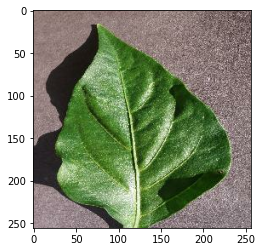

In [94]:
import numpy as np

for image_batch, labels in test_dataset.take(1):
    image = image_batch[0].numpy().astype("uint8")
    label = labels[0].numpy()
    
    print('Image to Predict :')
    plt.imshow(image)
    print('Actual Lable : ', class_names[label])
    
    batch_prediction = model.predict(image_batch)
    print('Predicted Label : ', class_names[np.argmax(batch_prediction[0])])

In [95]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    
    accuracy = round(100 * (np.max(predictions[0])), 2)
    
    return(predicted_class, accuracy)

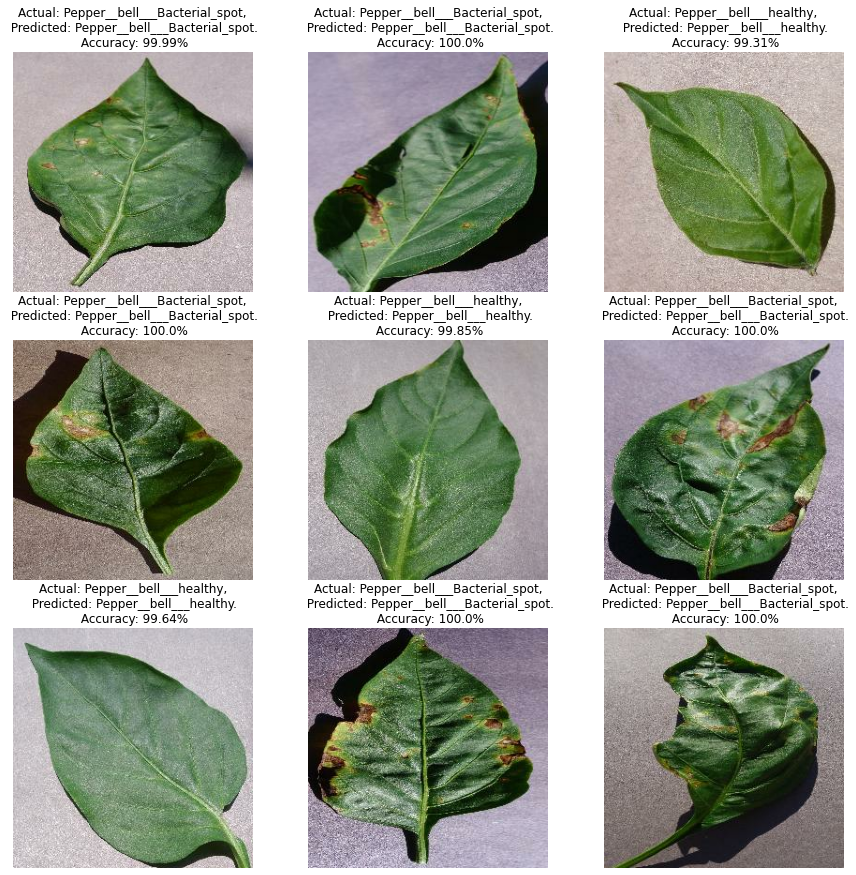

In [96]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, accuracy = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Accuracy: {accuracy}%")
        
        plt.axis("off")

# Saving the TF Lite Model¶

In [108]:
import os
model_version = max([int(i) for i in (os.listdir("tf-lite-models")+[0])]) + 1

with open(
    f"tf-lite-models/tf-lite-models-" + str(model_version) + ".tflite", 'wb') as f:
        f.write(quantized_tflite_model)